In [0]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset                  #for easy iteration of batches
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle as pkl
import torch
import random

In [0]:
#loading data

num_workers=0
batch_size=64
transform=transforms.ToTensor()
train_data=datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader=DataLoader(train_data, batch_size=batch_size,  num_workers=num_workers)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


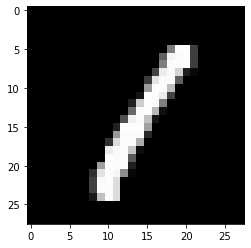

In [0]:
#visualising images

train_dataiter=iter(train_loader)
images, labels = next(train_dataiter)
images=images.numpy()
img=np.squeeze(images[3])
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.show()

In [0]:
#Discriminator

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_layers, output_size):
        super(Discriminator, self).__init__()

        #fcs
        self.fc1=nn.Linear(input_size, hidden_layers*4)
        self.fc2=nn.Linear(hidden_layers*4, hidden_layers*2)
        self.fc3=nn.Linear(hidden_layers*2, hidden_layers)
        self.fc4=nn.Linear(hidden_layers, output_size)

        #dropuots
        self.drop=nn.Dropout(p=0.3)

    def forward(self, x):

        x=x.view(-1, 28*28)

        out=F.leaky_relu(self.fc1(x), negative_slope=0.2)
        out=self.drop(out)

        out=F.leaky_relu(self.fc2(out), negative_slope=0.2)
        out=self.drop(out)

        out=F.leaky_relu(self.fc3(out), negative_slope=0.2)
        out=self.drop(out)

        out=self.fc4(out)

        return out

In [0]:
#Generator

class Generator(nn.Module):

    def __init__(self, input_size, hidden_layers, output_size):
        super(Generator, self).__init__()

        #fcs
        self.fc1=nn.Linear(input_size, hidden_layers*4)
        self.fc2=nn.Linear(hidden_layers*4, hidden_layers*2)
        self.fc3=nn.Linear(hidden_layers*2, hidden_layers)
        self.fc4=nn.Linear(hidden_layers, output_size)

        #dropuots
        self.drop=nn.Dropout(p=0.3)

    def forward(self, x):

        out=F.leaky_relu(self.fc1(x), negative_slope=0.2)
        out=self.drop(out)

        out=F.leaky_relu(self.fc2(out), negative_slope=0.2)
        out=self.drop(out)

        out=F.leaky_relu(self.fc3(out), negative_slope=0.2)
        out=self.drop(out)

        out=F.tanh(self.fc4(out))

        return out

In [0]:
#discriminator Hyperparameters

dis_input_size=28*28
dis_hidden_layer=32
dis_output_size=1

#generator Hyperparameters

gen_input_size=100
gen_hidden_size=32
gen_output_size=28*28

In [0]:
#instantiating discriminator and generator

discrim=Discriminator(dis_input_size, dis_hidden_layer, dis_output_size)
gener=Generator(gen_input_size, gen_hidden_size, gen_output_size)

print(discrim)
print(gener)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=784, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
)


In [0]:
#defining losses

def real_loss(D_out, smooth=False):
    
    batch_size=D_out.size(0)

    if smooth:
        labels=torch.ones(batch_size)*0.9
    else:
        labels=torch.ones(batch_size)

    criterion=nn.BCEWithLogitsLoss()

    loss=criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):

    batch_size=D_out.size(0)
    labels=torch.zeros(batch_size)

    criterion=nn.BCEWithLogitsLoss()

    loss=criterion(D_out.squeeze(), labels)
    return loss

In [0]:
#defining optimisers

learning_rate=0.002
des_opt=optim.Adam(discrim.parameters(), lr=learning_rate)
gen_opt=optim.Adam(gener.parameters(), lr=learning_rate)

In [0]:
#training the model

num_epochs=100
samples=[]
losses=[]
print_every=400

sample_size=16
fixed_z=np.random.uniform(-1, 1, size=(sample_size, gen_input_size))
fixed_z=torch.from_numpy(fixed_z).float()

discrim.train()
gener.train()

for epoch in range(num_epochs):

    for batch_i, (real_imgs, _) in enumerate(train_loader):
        
        batch_size=real_imgs.size(0)

        real_imgs=real_imgs*2-1

        #train discriminator

        des_opt.zero_grad()
        #real loss
        des_real=discrim(real_imgs)
        des_real_loss=real_loss(des_real, smooth=True)

        #fake loss
        z=np.random.uniform(-1, 1, size=(sample_size, gen_input_size))
        z=torch.from_numpy(z).float()
        fake_imgs=gener(z)

        des_fake=discrim(fake_imgs)
        des_fake_loss=fake_loss(des_fake)

        des_loss=des_real_loss+des_fake_loss

        des_loss.backward()
        des_opt.step()

        #train generator

        gen_opt.zero_grad()

        z=np.random.uniform(-1, 1, size=(batch_size, gen_input_size))
        z=torch.from_numpy(z).float()
        fake_imgs=gener(z)

        des_fake=discrim(fake_imgs)
        gen_loss=real_loss(des_fake)

        gen_loss.backward()
        gen_opt.step()

        if batch_i%print_every==0:
            print('Epoch [{}/{}]   d_loss: {}   g_loss: {}'.format(epoch+1, num_epochs, des_loss.item(), gen_loss.item()))

    losses.append((des_loss.item(), gen_loss.item()))

    gener.eval()
    samples_z=gener(fixed_z)
    samples.append(samples_z)
    gener.train()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [1/100]   d_loss: 1.3662283420562744   g_loss: 0.7041705846786499
Epoch [1/100]   d_loss: 0.4559861719608307   g_loss: 5.914693832397461
Epoch [1/100]   d_loss: 1.0384719371795654   g_loss: 2.5843758583068848
Epoch [2/100]   d_loss: 1.489032506942749   g_loss: 0.5180314183235168
Epoch [2/100]   d_loss: 0.9907869100570679   g_loss: 1.531641960144043
Epoch [2/100]   d_loss: 0.662439227104187   g_loss: 3.224583148956299
Epoch [3/100]   d_loss: 0.8265215158462524   g_loss: 2.5445337295532227
Epoch [3/100]   d_loss: 0.9407655000686646   g_loss: 1.6285052299499512
Epoch [3/100]   d_loss: 0.9219974279403687   g_loss: 1.5343276262283325
Epoch [4/100]   d_loss: 1.027603268623352   g_loss: 1.641624927520752
Epoch [4/100]   d_loss: 1.0957105159759521   g_loss: 1.390984058380127
Epoch [4/100]   d_loss: 1.0831282138824463   g_loss: 1.2397489547729492
Epoch [5/100]   d_loss: 1.1595826148986816   g_loss: 1.2933564186096191
Epoch [5/100]   d_loss: 0.9067459106445312   g_loss: 1.7024766206741333


In [0]:
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


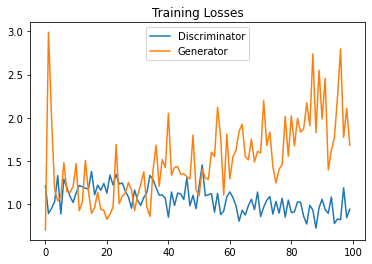

In [0]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [0]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [0]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

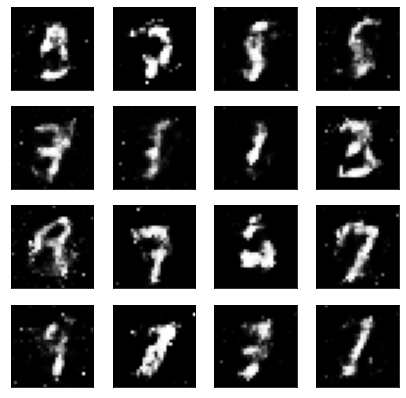

In [0]:

# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

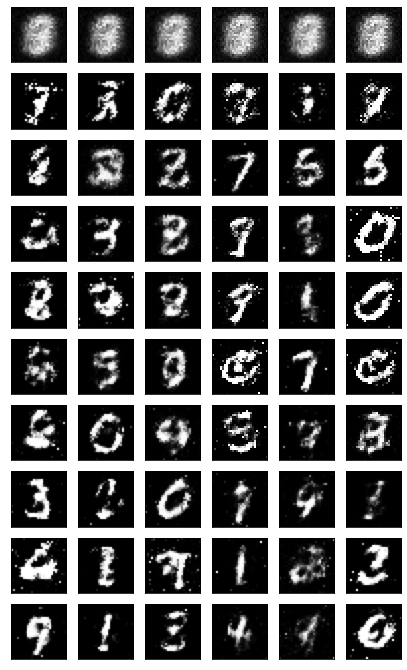

In [0]:

rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


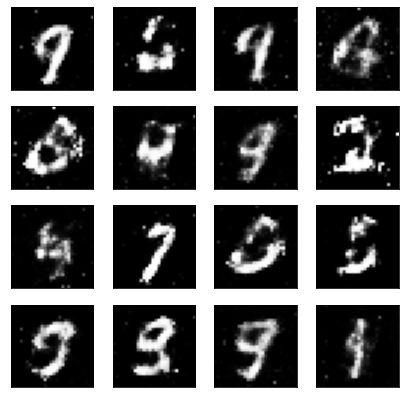

In [0]:
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, gen_input_size))
rand_z = torch.from_numpy(rand_z).float()

gener.eval() # eval mode
# generated samples
rand_images = gener(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])